<h1>Spam Detection — Modeling & Model Selection</h1>
<h2>Objectifs :
<ul>
<li>comparer plusieurs modèles via cross-validation</li>

<li>choisir le meilleur selon le F1-score (spam)</li>

<li>évaluer sur un test set avec matrice de confusion</li>

<li>sauvegarder le pipeline final pour Streamlit</li>
</ul>
</h2>

In [12]:
import re
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC

from sklearn.metrics import confusion_matrix, classification_report
import joblib



In [ ]:
#chargement des données brutes/Loading raw data
df = pd.read_csv("../data/spam.csv")

df = df.rename(columns=str.strip)
df["Category"] = df["Category"].astype(str).str.lower().str.strip()
df["Message"]  = df["Message"].astype(str)

df["label"] = df["Category"].map({"ham": 0, "spam": 1})
df = df.dropna(subset=["label"])
df["label"] = df["label"].astype(int)

X = df["Message"]
y = df["label"]

df.head()


,Category,Message,label
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


In [ ]:

df["Category"].value_counts()


Category
ham     4825
spam     747
Name: count, dtype: int64

In [16]:

def normalize_spam_patterns(text: str) -> str:
    text = text.lower()
    text = re.sub(r"http\S+|www\.\S+", " __URL__ ", text)
    text = re.sub(r"\b[\w\.-]+@[\w\.-]+\.\w+\b", " __EMAIL__ ", text)
    text = re.sub(r"\b\d+(\.\d+)?\b", " __NUMBER__ ", text)
    text = re.sub(r"[$€£]\s*\d+", " __MONEY__ ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text


In [17]:

def make_pipeline(model):
    return Pipeline([
        ("tfidf", TfidfVectorizer(
            preprocessor=normalize_spam_patterns,
            stop_words="english",
            ngram_range=(1, 2),
            min_df=2,
            max_df=0.95,
            sublinear_tf=True,
            strip_accents="unicode"
        )),
        ("clf", model)
    ])


In [18]:
models = {
    "MultinomialNB": MultinomialNB(),
    "LogisticRegression": LogisticRegression(max_iter=2000, class_weight="balanced"),
    "LinearSVC": LinearSVC(class_weight="balanced"),
    "SGDClassifier": SGDClassifier(loss="hinge", class_weight="balanced", random_state=42),
}


In [19]:

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_results = {}

for name, model in models.items():
    pipe = make_pipeline(model)
    scores = cross_val_score(pipe, X, y, cv=cv, scoring="f1")
    cv_results[name] = scores.mean()
    print(f"{name:20s} | F1 (CV) = {cv_results[name]:.4f}")


MultinomialNB        | F1 (CV) = 0.8930
LogisticRegression   | F1 (CV) = 0.9077
LinearSVC            | F1 (CV) = 0.9473
SGDClassifier        | F1 (CV) = 0.9449


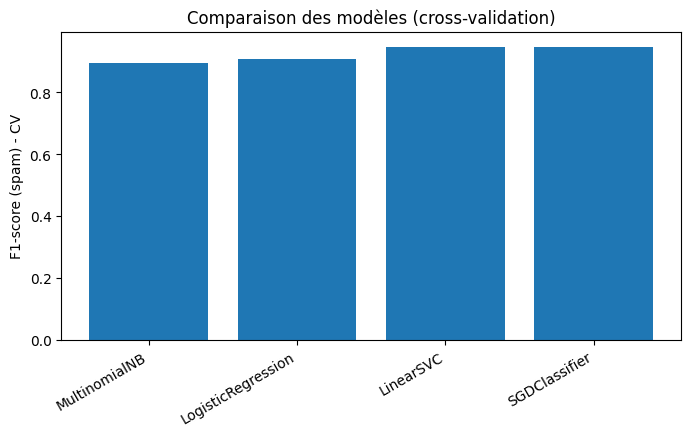

In [20]:

plt.figure(figsize=(8,4))
plt.bar(cv_results.keys(), cv_results.values())
plt.ylabel("F1-score (spam) - CV")
plt.title("Comparaison des modèles (cross-validation)")
plt.xticks(rotation=30, ha="right")
plt.show()


In [21]:
best_model_name = max(cv_results, key=cv_results.get)
best_model_name


'LinearSVC'

<pre>Le modèle (LinearSVC) obtient le meilleur F1-score moyen en cross-validation. 
Il est sélectionné pour l’entraînement final et le déploiement.</pre>

In [22]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

best_pipeline = make_pipeline(models[best_model_name])
best_pipeline.fit(X_train, y_train)

y_pred = best_pipeline.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
print("=== Confusion Matrix ===")
print(cm)

print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred, target_names=["ham", "spam"]))


=== Confusion Matrix ===
[[959   7]
 [  7 142]]

=== Classification Report ===
              precision    recall  f1-score   support

         ham       0.99      0.99      0.99       966
        spam       0.95      0.95      0.95       149

    accuracy                           0.99      1115
   macro avg       0.97      0.97      0.97      1115
weighted avg       0.99      0.99      0.99      1115



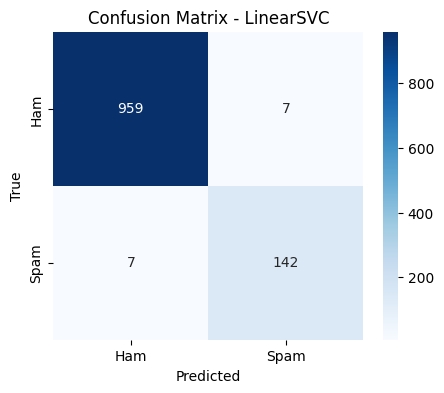

In [23]:

plt.figure(figsize=(5,4))
sns.heatmap(
    cm, annot=True, fmt="d", cmap="Blues",
    xticklabels=["Ham", "Spam"],
    yticklabels=["Ham", "Spam"]
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Confusion Matrix - {best_model_name}")
plt.show()


In [24]:
final_pipeline = make_pipeline(models[best_model_name])
final_pipeline.fit(X, y)


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('tfidf', ...), ('clf', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"input input: {'filename', 'file', 'content'}, default='content'- If `'filename'`, the sequence passed as an argument to fit is expected to be a list of filenames that need reading to fetch the raw content to analyze.- If `'file'`, the sequence items must have a 'read' method (file-like object) that is called to fetch the bytes in memory.- If `'content'`, the input is expected to be a sequence of items that can be of type string or byte.",'content'
,"encoding encoding: str, default='utf-8'If bytes or files are given to analyze, this encoding is used todecode.",'utf-8'
,"decode_error decode_error: {'strict', 'ignore', 'replace'}, default='strict'Instruction on what to do if a byte sequence is given to analyze thatcontains characters not of the given `encoding`. By default, it is'strict', meaning that a UnicodeDecodeError will be raised. Othervalues are 'ignore' and 'replace'.",'strict'
,"strip_accents strip_accents: {'ascii', 'unicode'} or callable, default=NoneRemove accents and perform other character normalizationduring the preprocessing step.'ascii' is a fast method that only works on characters that havea direct ASCII mapping.'unicode' is a slightly slower method that works on any characters.None (default) means no character normalization is performed.Both 'ascii' and 'unicode' use NFKD normalization from:func:`unicodedata.normalize`.",'unicode'
,"lowercase lowercase: bool, default=TrueConvert all characters to lowercase before tokenizing.",True
,"preprocessor preprocessor: callable, default=NoneOverride the preprocessing (string transformation) stage whilepreserving the tokenizing and n-grams generation steps.Only applies if ``analyzer`` is not callable.",<function nor...001511B2B2C00>
,"tokenizer tokenizer: callable, default=NoneOverride the string tokenization step while preserving thepreprocessing and n-grams generation steps.Only applies if ``analyzer == 'word'``.",None


In [26]:
joblib.dump(final_pipeline, "../models/spam_pipeline.pkl")
print("Pipeline sauvegardé : ../models/spam_pipeline.pkl")


Pipeline sauvegardé : ../models/spam_pipeline.pkl


<h1>Conclusion</h1>
<p>Le prétraitement, la vectorisation TF-IDF et le classifieur sont intégrés dans un pipeline unique, ce qui garantit la cohérence entre l’entraînement, l’évaluation et le déploiement Streamlit.</p>